#Implementing CNN with CIFAR_10 Dataset

Here I'm going to implement the Convolutional Neural networks on CIFAR-10 dataset using pytorch library:<br>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

<p>=> Loading the data from datasets library, and applying some transformations Like:<br>
-tranforming data to tensors for further usage.<br>
-Applying some data manipulative transformations for better accuracies and to avoid overfiiting.<br>
-Here i used normalise,Randomcrop and Randomflips.</p>

In [ ]:
from torchvision import datasets
from torchvision import transforms

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
])

train_data =datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform = train_transform,
)
test_data =datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform = transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
random_seed = 56
torch.manual_seed(random_seed);
batch_size=128

<h>Splitting data into training and validation datasets</h>

In [ ]:
from torch.utils.data import random_split

val_size = 5000
train_size = len(train_data) - val_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

Loading the data in batches which would helpful during training and evaluation.

In [ ]:
from torch.utils.data.dataloader import DataLoader

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Displaying some images from the dataset help us to understand more about the data and its classes.

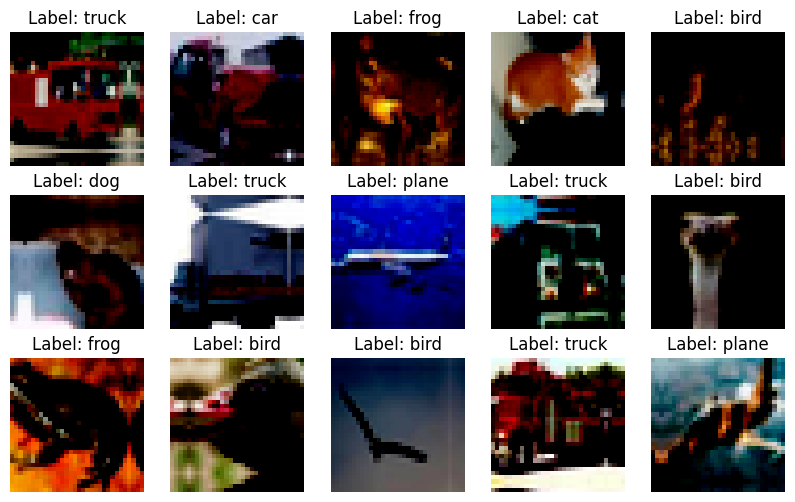

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

random.seed(random_seed)
num_rows = 3
num_cols = 5
Labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))
for i in range(num_rows*num_cols):
  x=random.randint(0,50000)
  sample_image,label=train_data[x]
  row = i // num_cols
  col = i % num_cols

  axes[row, col].imshow(np.transpose(sample_image, (1, 2, 0)))
  axes[row, col].set_title(f"Label: {Labels[label]}")
  axes[row, col].axis('off')

  i+=1

defined some function in the cnn class which are usefull during the evaluation and training of model.

In [ ]:
import torch.nn.functional as F

class cnn(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Finally here i defined the architecture of model.<br>
this is a basic cnn model and here I modified architecture according to resulting accuracies on test data. <br>
modified parameters like stride, padding and kernel size. I didnt tried all combination but the  one with stride=1 and padding=1 kernel size=3 given the best accuracies of all.<br>
Here i used relu activation function and also added some pooling layers(max pooling).


In [ ]:
class Cifar10CnnModel(cnn):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=8192, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=512, out_features=10, bias=True)
  )
)

For fast computing i need to run the model on gpu so by using below defined function i can change the device to cuda or if not available device to cpu.

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);
device

device(type='cuda')

And here comes the training loop.<br>
to learn the weights more accuratley i need to tune the parameters like no. of epoches , learning rate to get best accuracies.<br>
To get idea of what going on and how model is working i need to keep track training losses and validation loss and validation accuracies.



In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl,opt_func)

Epoch [1], train_loss: 0.3788, val_loss: 0.5220, val_acc: 0.8384
Epoch [2], train_loss: 0.3639, val_loss: 0.5296, val_acc: 0.8222
Epoch [3], train_loss: 0.3487, val_loss: 0.5131, val_acc: 0.8299
Epoch [4], train_loss: 0.3374, val_loss: 0.5241, val_acc: 0.8341
Epoch [5], train_loss: 0.3199, val_loss: 0.5464, val_acc: 0.8249
Epoch [6], train_loss: 0.3172, val_loss: 0.5314, val_acc: 0.8341
Epoch [7], train_loss: 0.3066, val_loss: 0.4982, val_acc: 0.8411
Epoch [8], train_loss: 0.2990, val_loss: 0.5225, val_acc: 0.8326
Epoch [9], train_loss: 0.2877, val_loss: 0.5386, val_acc: 0.8321
Epoch [10], train_loss: 0.2736, val_loss: 0.5245, val_acc: 0.8439
Epoch [11], train_loss: 0.2782, val_loss: 0.5754, val_acc: 0.8297
Epoch [12], train_loss: 0.2644, val_loss: 0.5937, val_acc: 0.8314
Epoch [13], train_loss: 0.2578, val_loss: 0.5105, val_acc: 0.8386
Epoch [14], train_loss: 0.2565, val_loss: 0.5327, val_acc: 0.8426
Epoch [15], train_loss: 0.2536, val_loss: 0.5289, val_acc: 0.8443


And plotting the results that we got from our model training process.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

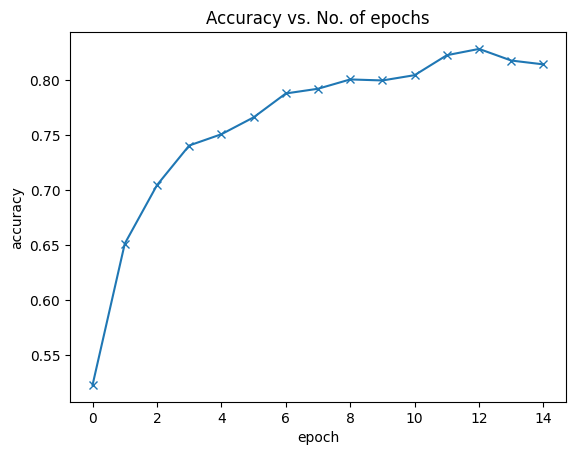

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

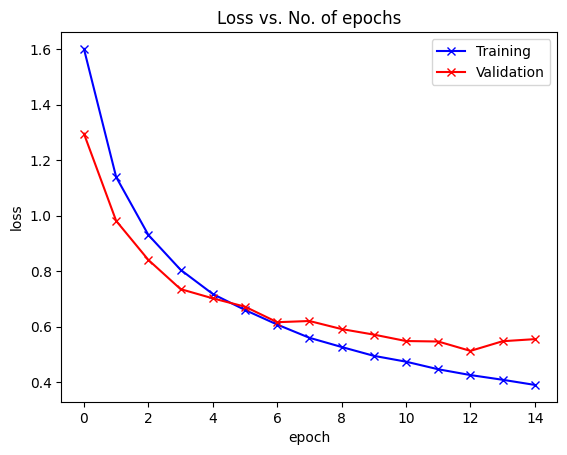

In [ ]:
plot_losses(history)

At last we need to know how our model works on the unseen data i.e test data.
we got **86%** of accuracy.

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_data, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.4754141867160797, 'val_acc': 0.862011730670929}